In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
import os
import copy
import random

from python_files_of_notebooks.transforms import (
    apply_and_visualize_transform,
    PartialVolumeArtifactTransform,
    StreakArtifactTransform,
    RingArtifactTransform,
    ZebraArtifactTransform,
    spatial_transform,
    gaussian_noise_transform,
    gaussian_blur_transform,
    brightness_transform,
    contrast_transform,
    lowres_transform,
    gamma_transform,
    mirror_transform,
    sharpening_transform,
    rot_90_transform,
    transpose_axes_transform
)

In [2]:
minor_MED_transforms = [PartialVolumeArtifactTransform, StreakArtifactTransform, RingArtifactTransform, ZebraArtifactTransform]
medium_MED_transforms = [gamma_transform(ranges=(0.5,2)), gaussian_blur_transform(blur_sigma=25), sharpening_transform(strength=(0.1, 0.3))]
major_MED_transforms = [gaussian_noise_transform(0, 20), lowres_transform(zoom_range=(0.7,1)), brightness_transform(0, 1000)]
MED_transforms = (minor_MED_transforms, medium_MED_transforms, major_MED_transforms)

minor_AI_transforms = [sharpening_transform(strength=(0.1, 0.3)), rot_90_transform(num_rot=(1,2,3)), transpose_axes_transform(transpose_any_of_these=(0,1,2))]
medium_AI_transforms = [gamma_transform(ranges=(0.5,2)), gaussian_blur_transform(blur_sigma=25), sharpening_transform(strength=(0.1, 0.3))]
major_AI_transforms = [gaussian_noise_transform(0, 20), lowres_transform(zoom_range=(0.7,1)), brightness_transform(0, 1000)]
AI_transforms = (minor_AI_transforms, medium_AI_transforms, major_AI_transforms)

minor_ALL_transforms = [PartialVolumeArtifactTransform, StreakArtifactTransform, RingArtifactTransform, ZebraArtifactTransform, sharpening_transform(strength=(0.1, 0.3)), rot_90_transform(num_rot=(1,2,3)), transpose_axes_transform(transpose_any_of_these=(0,1,2))]
medium_ALL_transforms = [gamma_transform(ranges=(0.5,2)), gaussian_blur_transform(blur_sigma=25), sharpening_transform(strength=(0.1, 0.3))]
major_ALL_transforms = [gaussian_noise_transform(0, 20), lowres_transform(zoom_range=(0.7,1)), brightness_transform(0, 1000)]
ALL_transforms = (minor_ALL_transforms, medium_ALL_transforms, major_ALL_transforms)


gt_transforms = [type(rot_90_transform(num_rot=(1,2,3))), type(transpose_axes_transform(transpose_any_of_these=(0,1,2)))]

In [3]:
input_file_path = Path("..") / "data" / "SEGTHOR_3D" / "train" / "img" / "Patient_04.nii.gz"
real_1 = nib.load(input_file_path)
image_data = real_1.get_fdata()
image_data = image_data[np.newaxis, np.newaxis, ...]
slice_number = 50
patch_size = (128, 128, 128)

In [14]:
gt_path = Path("..") / "data" / "SEGTHOR_3D" / "train" / "gt" / "Patient_04.nii.gz"
real_GT_1 = nib.load(gt_path)
image_data_GT = real_GT_1.get_fdata()
image_data_GT = image_data_GT[np.newaxis, np.newaxis, ...]

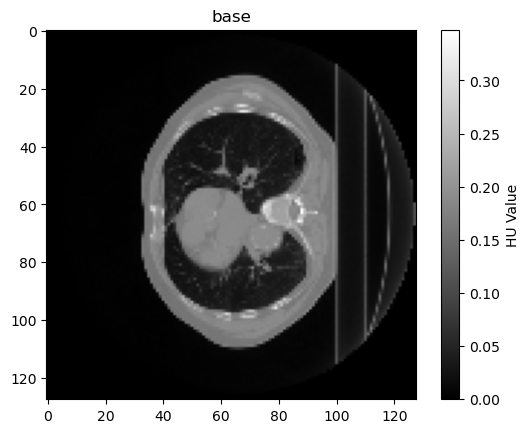

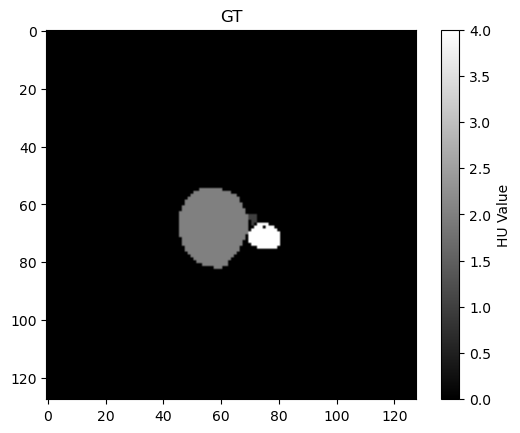

In [5]:
apply_and_visualize_transform(None, image_data, slice_number, "base", image_data_GT)

In [6]:
np.random.seed(42)

In [7]:
def apply_random_transforms(image, gt, transform_list, gt_transforms):
    """Applies transforms to the image, and to the ground truth (gt) if needed."""
    artifact_types = [type(PartialVolumeArtifactTransform), type(StreakArtifactTransform), type(RingArtifactTransform), type(ZebraArtifactTransform)]
    
    for transform in transform_list:
        if type(transform) in artifact_types:
            image = transform()(data=image)
        else:
            image = transform(data=image)  # Apply the transform to the image

        # Check if this transform should be applied to the GT (ground truth)
        if type(transform) in gt_transforms:
            gt = transform(data=gt)  # Apply the same transform to the ground truth

        if isinstance(gt, dict):
            gt = gt['data']
        if isinstance(image, dict):
            image = image['data']

    return image, gt

def apply_transformations(gt_data, image_data, transforms, gt_transforms):
    minor_transforms, medium_transforms, major_transforms = transforms

    # Define transformation patterns for each image
    transform_patterns = [
        {"major": 1, "medium": 1, "minor": 0},  # 1: major, medium
        {"major": 2, "medium": 1, "minor": 0},  # 2: major, major, medium
        {"major": 1, "medium": 1, "minor": 1},  # 3: major, medium, minor
        {"major": 2, "medium": 2, "minor": 1},  # 4: major, major, medium, medium, minor
        {"major": 2, "medium": 1, "minor": 1}   # 5: major, major, medium, minor
    ]

    transformed_images = []
    transformed_gts = []
    
    for pattern in transform_patterns:
        transformed_image = copy.deepcopy(image_data)
        transformed_gt = copy.deepcopy(gt_data)  # Deep copy GT to ensure it's a separate instance
        applied_transforms = []

        # Apply the number of major transforms
        if pattern["major"] > 0:
            applied_transforms.extend(random.sample(major_MED_transforms, pattern["major"]))

        # Apply the number of medium transforms
        if pattern["medium"] > 0:
            applied_transforms.extend(random.sample(medium_MED_transforms, pattern["medium"]))

        # Apply the number of minor transforms
        if pattern["minor"] > 0:
            applied_transforms.extend(random.sample(minor_MED_transforms, pattern["minor"]))

        # Apply the selected transforms to both the image and ground truth where necessary
        transformed_image, transformed_gt = apply_random_transforms(
            transformed_image, transformed_gt, applied_transforms, gt_transforms
        )

        # Append the transformed image and GT to their respective lists
        transformed_images.append(transformed_image)
        transformed_gts.append(transformed_gt)

    return [
        gt_data, image_data,
        transformed_gts[0], transformed_images[0],
        transformed_gts[1], transformed_images[1],
        transformed_gts[2], transformed_images[2],
        transformed_gts[3], transformed_images[3],
        transformed_gts[4], transformed_images[4],
    ]

In [31]:
def save_array_as_nii(array, filename, niifile):
    """
    Converts a 3D NumPy array into a NIfTI (.nii) file.
    
    Args:
        array (np.ndarray): 3D NumPy array to be converted.
        filename (str): Path to save the NIfTI file (with .nii extension).
    
    Returns:
        None
    """
    # Convert NumPy array to a NIfTI image

    array = array.reshape(128,128,128)
    
    nii_image = nib.Nifti1Image(array, affine=niifile.affine, header=niifile.header)
    
    # Save the NIfTI image to a file
    nib.save(nii_image, filename)


In [33]:
# fill the training
for file in os.listdir(Path("..") / "data" / "SEGTHOR_3D" / "train" / "gt"):

    patient_number = file.split(".")[0][-2:]
    patient_file_path = Path("..") / "data" / "SEGTHOR_3D" / "train" / "img" / file
    gt_file_path = Path("..") / "data" / "SEGTHOR_3D" / "train" / "gt" / file

    new_patient_file_path_med = Path("..") / "data" / "SEGTHOR_3D_MED" / "train" / "img"
    new_gt_file_path_med = Path("..") / "data" / "SEGTHOR_3D_MED" / "train" / "gt"

    new_patient_file_path_ai = Path("..") / "data" / "SEGTHOR_3D_AI" / "train" / "img"
    new_gt_file_path_ai = Path("..") / "data" / "SEGTHOR_3D_AI" / "train" / "gt"

    new_patient_file_path_all = Path("..") / "data" / "SEGTHOR_3D_ALL" / "train" / "img"
    new_gt_file_path_all = Path("..") / "data" / "SEGTHOR_3D_ALL" / "train" / "gt"

    patient_data = nib.load(patient_file_path)
    patient_nii = copy.deepcopy(patient_data)
    patient_data = patient_data.get_fdata()
    patient_data = patient_data[np.newaxis, np.newaxis, ...]

    gt_data = nib.load(gt_file_path)
    gt_nii = copy.deepcopy(gt_data)
    gt_data = gt_data.get_fdata()
    gt_data = gt_data[np.newaxis, np.newaxis, ...]

    # MED_results = apply_transformations(gt_data, image_data, MED_transforms, gt_transforms)
    # AI_results = apply_transformations(gt_data, image_data, AI_transforms, gt_transforms)
    # ALL_results = apply_transformations(gt_data, image_data, MED_transforms, gt_transforms)
    
    patnum = 0
    gtnum = 0
    for i, (MED_result, AI_result, ALL_result) in enumerate(zip(MED_results, AI_results, ALL_results)):
        if i % 2 == 0:
            # patients
            patnum += 1
            patnum_in_amt = "{:04d}".format(patnum)
            save_array_as_nii(MED_result, new_patient_file_path_med / f"Patient_{patient_number}_{patnum_in_amt}", patient_nii)
            save_array_as_nii(AI_result, new_patient_file_path_ai / f"Patient_{patient_number}_{patnum_in_amt}", patient_nii)
            save_array_as_nii(ALL_result, new_patient_file_path_ai / f"Patient_{patient_number}_{patnum_in_amt}", patient_nii)
        else:
            # GT
            gtnum += 1
            gtnum_in_amt = "{:04d}".format(gtnum)
            save_array_as_nii(MED_result, new_gt_file_path_med / f"Patient_{patient_number}_{patnum_in_amt}", gt_nii)
            save_array_as_nii(AI_result, new_gt_file_path_ai / f"Patient_{patient_number}_{patnum_in_amt}", gt_nii)
            save_array_as_nii(ALL_result, new_gt_file_path_ai / f"Patient_{patient_number}_{patnum_in_amt}", gt_nii)


In [10]:
# fill the validation
for file in os.listdir(Path("..") / "data" / "SEGTHOR_3D" / "val" / "gt"):

    patient_number = file.split(".")[0][-2:]
    patient_file_path = Path("..") / "data" / "SEGTHOR_3D" / "val" / "img" / file
    gt_file_path = Path("..") / "data" / "SEGTHOR_3D" / "val" / "gt" / file

    new_patient_file_path_med = Path("..") / "data" / "SEGTHOR_3D_MED" / "val" / "img"
    new_gt_file_path_med = Path("..") / "data" / "SEGTHOR_3D_MED" / "val" / "gt"

    new_patient_file_path_ai = Path("..") / "data" / "SEGTHOR_3D_AI" / "val" / "img"
    new_gt_file_path_ai = Path("..") / "data" / "SEGTHOR_3D_AI" / "val" / "gt"

    new_patient_file_path_all = Path("..") / "data" / "SEGTHOR_3D_ALL" / "val" / "img"
    new_gt_file_path_all = Path("..") / "data" / "SEGTHOR_3D_ALL" / "val" / "gt"

    patient_data = nib.load(patient_file_path)
    patient_nii = copy.deepcopy(patient_data)
    patient_data = patient_data.get_fdata()
    patient_data = patient_data[np.newaxis, np.newaxis, ...]

    gt_data = nib.load(gt_file_path)
    gt_nii = copy.deepcopy(gt_data)
    gt_data = gt_data.get_fdata()
    gt_data = gt_data[np.newaxis, np.newaxis, ...]

    MED_results = apply_transformations(gt_data, image_data, MED_transforms, gt_transforms)
    AI_results = apply_transformations(gt_data, image_data, AI_transforms, gt_transforms)
    ALL_results = apply_transformations(gt_data, image_data, MED_transforms, gt_transforms)
    
    patnum = 0
    gtnum = 0
    for i, (MED_result, AI_result, ALL_result) in enumerate(zip(MED_results, AI_results, ALL_results)):
        if i % 2 == 0:
            # patients
            patnum += 1
            patnum_in_amt = "{:04d}".format(patnum)
            save_array_as_nii(MED_result, new_patient_file_path_med / f"Patient_{patient_number}_{patnum_in_amt}", patient_nii)
            save_array_as_nii(AI_result, new_patient_file_path_ai / f"Patient_{patient_number}_{patnum_in_amt}", patient_nii)
            save_array_as_nii(ALL_result, new_patient_file_path_ai / f"Patient_{patient_number}_{patnum_in_amt}", patient_nii)
        else:
            # GT
            gtnum += 1
            gtnum_in_amt = "{:04d}".format(gtnum)
            save_array_as_nii(MED_result, new_gt_file_path_med / f"Patient_{patient_number}_{patnum_in_amt}", gt_nii)
            save_array_as_nii(AI_result, new_gt_file_path_ai / f"Patient_{patient_number}_{patnum_in_amt}", gt_nii)
            save_array_as_nii(ALL_result, new_gt_file_path_ai / f"Patient_{patient_number}_{patnum_in_amt}", gt_nii)
